# Method testing
Finding the times by visual observation and applying the concluded method to the chosen period.

In [1]:
# data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate

%matplotlib inline
sns.set(color_codes=True)
pd.options.mode.chained_assignment = None 

path = '../datasets/'

dfrat = pd.read_hdf(path+'relationalDatabase.h5', 'Rat_Behavior').set_index('index')
dfevent   = pd.read_hdf(path+'relationalDatabase.h5', 'Events').set_index('index')
dfsession = pd.read_hdf(path+'relationalDatabase.h5', 'Sessions').set_index('index')

In [2]:
dfsession.head()

,session_id,rat_id,date,experimenter,original_name,video_name,VRspeed
index,,,,,,,
0,0,VR-4A,2017-07-13 02.39.20.315 PM,Nicholas A. Del Grosso,VRAcuityExp_2017-07-13_14-39-17_VR-4A_NIC,VRAcuityExp_2017-07-13_14-39-17_VR-4A_NIC-Came...,[ 0. 7. 14. 28.]
1,1,VR-2B,2017-07-13 03.05.18.468 PM,Nicholas A. Del Grosso,VRAcuityExp_2017-07-13_15-05-16_VR-2B_NIC,VRAcuityExp_2017-07-13_15-05-16_VR-2B_NIC-Came...,[ 0. 7. 14. 28.]
2,2,VR-2A,2017-07-13 03.19.28.235 PM,Eduardo Blanco-Hernandez,VRAcuityExp_2017-07-13_15-19-09_VR-2A_EDU,VRAcuityExp_2017-07-13_15-19-09_VR-2A_EDU-Came...,[ 0. 7. 14. 28.]
3,3,VR-1A,2017-07-13 03.38.35.628 PM,Nicholas A. Del Grosso,VRAcuityExp_2017-07-13_15-38-34_VR-1A_NIC,VRAcuityExp_2017-07-13_15-38-34_VR-1A_NIC-Came...,[ 0. 7. 14. 28.]
4,4,VR-1B,2017-07-13 03.53.42.156 PM,Nicholas A. Del Grosso,VRAcuityExp_2017-07-13_15-53-40_VR-1B_NIC,VRAcuityExp_2017-07-13_15-53-40_VR-1B_NIC-Came...,[ 0. 7. 14. 28.]


In [3]:
dfV = dfrat.copy()
dd = dfV[dfV['session_id']==1]

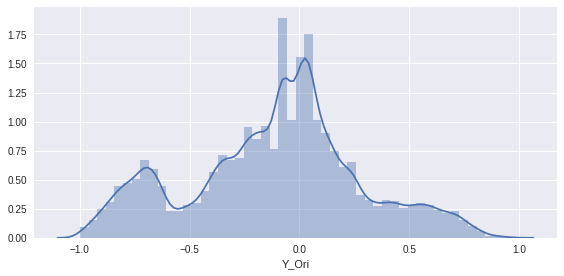

In [4]:
g = sns.FacetGrid(hue='session_id', data=dd, size=4, aspect=2)
g.map(sns.distplot, 'Y_Ori');

In [5]:
# Applying the Y_Pos LPfilter and Y_Ori filter
# rearing
rearinglimit = 0.13
dd = dd[dd['Y_Pos'] < rearinglimit]

# cleaning
dd = dd[(dd['Y_Ori'] >-0.75) & (dd['Y_Pos'] > 0.07)]

In [6]:
colChoice = ['X_Pos', 'Y_Pos', 'Z_Pos', 'X_Ori', 'Y_Ori', 'Z_Ori']

# smoothing the data
dd[colChoice] = dd[colChoice].rolling(window=100).mean()
dd.dropna(inplace=True)

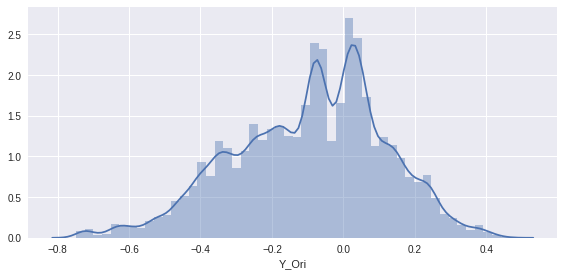

In [7]:
g = sns.FacetGrid(hue='session_id', data=dd, size=4, aspect=2)
g.map(sns.distplot, 'Y_Ori');

In [8]:
dd['dT'] = dd['Time'].diff(1)
dd['lVo'] = np.linalg.norm(np.array([dd.X_Ori, dd.Y_Ori, dd.Z_Ori])  )
dd['lx1'] = dd['X_Ori'] / dd['lVo']
dd['lz1'] = dd['Z_Ori'] / dd['lVo']
    
# normalize the data to unit vector form
dd['V1'] = np.linalg.norm(np.array([dd.lx1, 0, dd.lz1]))
dd['lx1'] = dd.lx1 / dd.V1
dd['lz1'] = dd.lz1 / dd.V1

# dd['V1'] = np.linalg.norm(np.array([dd.X_Ori, 0, dd.Z_Ori]))
# dd['lx1'] = dd.X_Ori / dd.V1
# dd['lz1'] = dd.Z_Ori / dd.V1

In [9]:
## ANGLES and VELOCITY

# calculatinig the angles between X axis and the vectors
V1 = np.array([dd.lx1, 0, dd.lz1])
V2 = np.array([1     , 0, 0     ])
    
dd['theta0'] = np.arccos(dd.lx1 / (np.linalg.norm(V1) * np.linalg.norm(V2)))
dd['theta1'] = dd.theta0.shift(1)
dd['theta']  = dd.theta0 - dd.theta1
dd.drop({'theta0','theta1'}, axis=1, inplace=True)
    
# angular velocity between two vectors
dd['U'] = np.degrees(dd.theta)/ dd.dT
dd['UM'] = dd['U'].rolling(window=20).mean()
    
# filtering out big time gaps frame points
dd = dd[np.absolute(dd['dT'])<0.005]

In [10]:
dfeventsClean = dfevent.drop({'MotiveExpTimeSecs'}, axis=1)
dd = pd.merge(dd, dfeventsClean, on=['Time', 'session_id','Frame'])

dd['subUM']  = dd['speed'] - dd['UM'] 
dd['subU']   = dd['speed'] - dd['U'] 

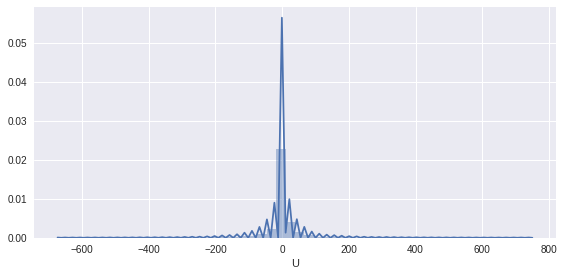

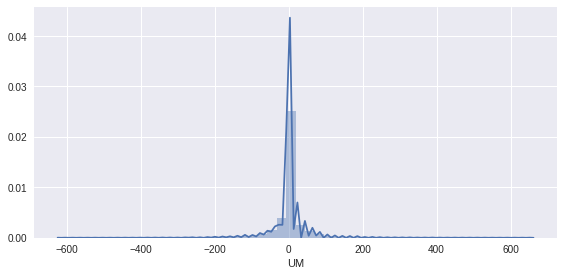

In [11]:
g = sns.FacetGrid(hue='session_id', data=dd, size=4, aspect=2)
g.map(sns.distplot, 'U');

g = sns.FacetGrid(hue='session_id', data=dd, size=4, aspect=2)
g.map(sns.distplot, 'UM');

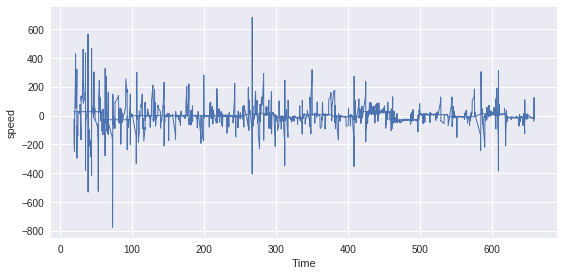

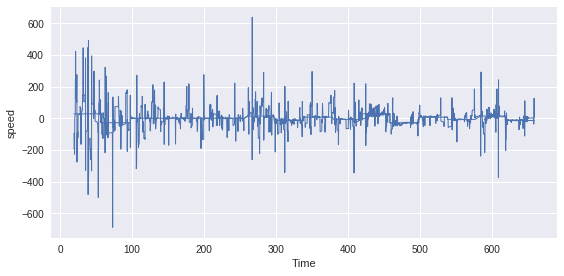

In [12]:
g = sns.FacetGrid(data=dd, size=4, aspect=2)
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);

g = sns.FacetGrid(data=dd, size=4, aspect=2)
g.map(plt.plot, "Time", "subUM", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);


## Time 1

In [13]:
dpart = dd[dd['Time']<295]
dpart = dpart[dpart['Time']>275]

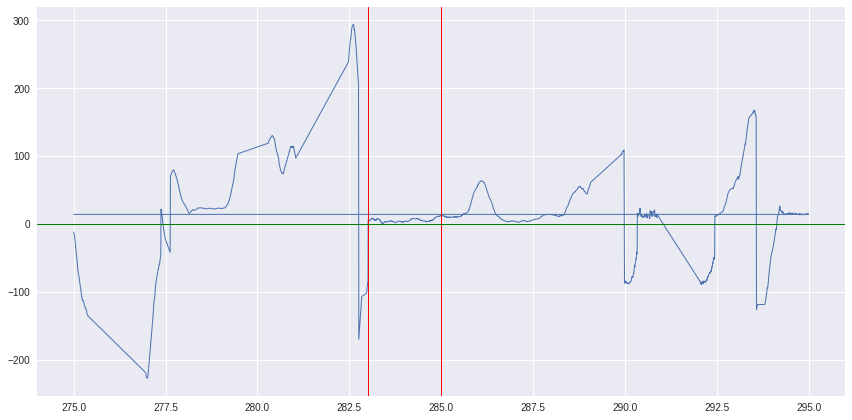

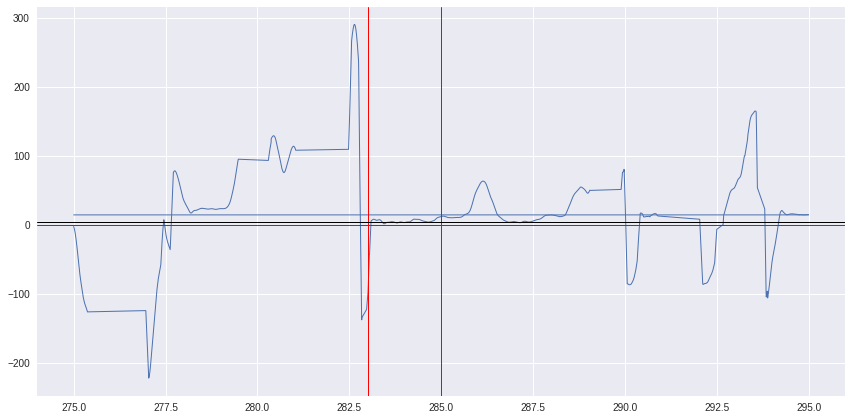

In [14]:
g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.axvline, x=285, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=283, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');

g = sns.FacetGrid(data=dpart, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "subUM", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.axvline, x=285, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=283, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');
g.map(plt.axhline, y=4.2, alpha=1, linewidth=1, color='black');


## Time 2

In [15]:
dpart2 = dd[dd['Time']<320]
dpart2 = dpart2[dpart2['Time']>300]

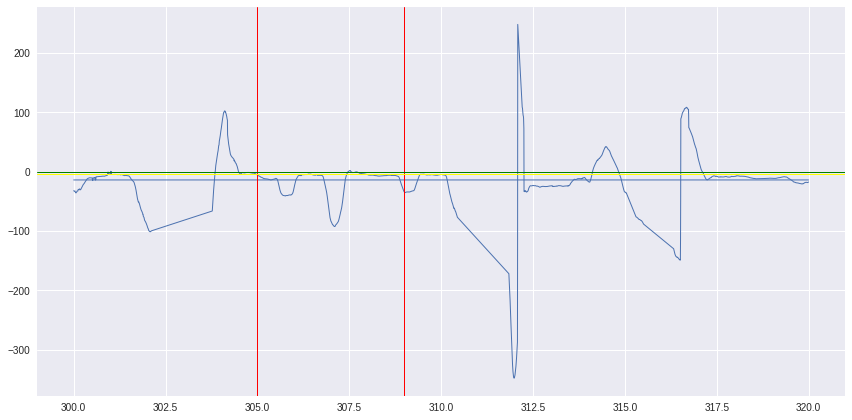

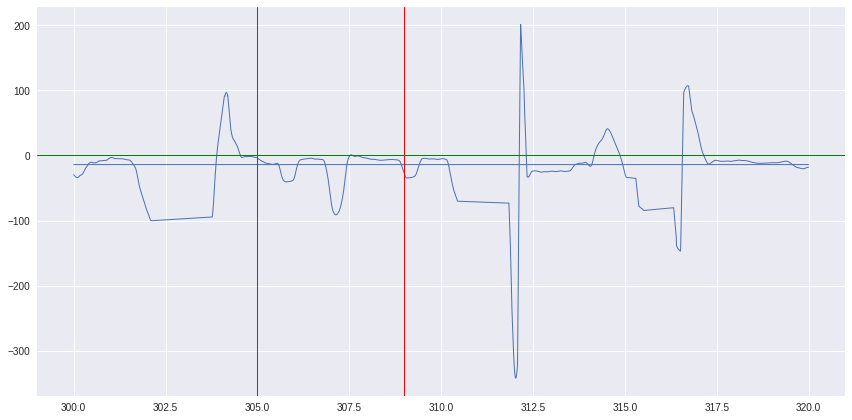

In [16]:
g = sns.FacetGrid(data=dpart2, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.axvline, x=305, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=309, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');
g.map(plt.axhline, y=-4, alpha=1, linewidth=1, color='yellow');

g = sns.FacetGrid(data=dpart2, size=6, aspect=2)
g.map(plt.plot, "Time", "subUM", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.axvline, x=305, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=309, alpha=1, linewidth=1, color='red');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');


## Time 3

In [17]:
dpart3 = dd[dd['Time']<90]
dpart3 = dpart3[dpart3['Time']>70]
# dpart2.head()

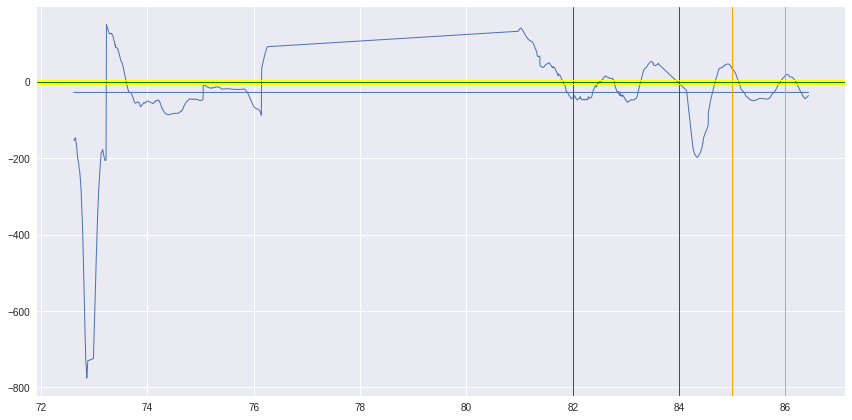

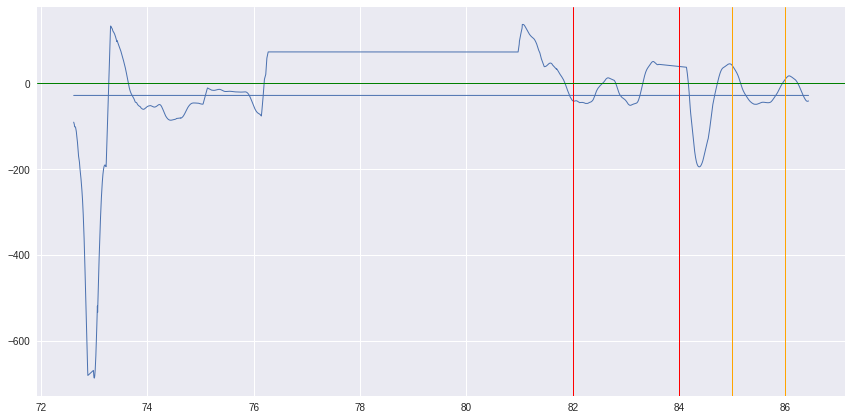

In [18]:
g = sns.FacetGrid(data=dpart3, size=6, aspect=2)#, ylim=[-30,30])
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.axvline, x=82, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=84, alpha=1, linewidth=1, color='red');

g.map(plt.axvline, x=85, alpha=1, linewidth=1, color='orange');
g.map(plt.axvline, x=86, alpha=1, linewidth=1, color='orange');

g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');
g.map(plt.axhline, y=-5.6, alpha=1, linewidth=1, color='yellow');
g.map(plt.axhline, y= 5.6, alpha=1, linewidth=1, color='yellow');


g = sns.FacetGrid(data=dpart3, size=6, aspect=2)
g.map(plt.plot, "Time", "subUM", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);
g.map(plt.axvline, x=82, alpha=1, linewidth=1, color='red');
g.map(plt.axvline, x=84, alpha=1, linewidth=1, color='red');

g.map(plt.axvline, x=85, alpha=1, linewidth=1, color='orange');
g.map(plt.axvline, x=86, alpha=1, linewidth=1, color='orange');
g.map(plt.axhline, y=0, alpha=1, linewidth=1, color='green');
